# Factors Contributing To Longer Duration Of Bike Rentals

## Investigation Overview

In this investigation, I wanted to look at the factors contributing to longer duration of bike rentals for Bay Wheels. The 4 main features I will focus on are *user types*, *start hour* of rentals, *weekdays* of rental and *location of pick-up and drop-off depot*. 

## Dataset Overview

The data consisted of approx. 296,000 bike rentals information, which included the bike rental duration, start time (which consisted of the date and time of rental), depot location details and user types. 1006 data points were moved as they were considered outliers and created nuances in the dataset.

In [25]:
import pandas as pd
import numpy as np
import seaborn as sb
import datetime
import time
import matplotlib.pyplot as plt 

%matplotlib inline

In [26]:
tripdata = pd.read_csv('202001-baywheels-tripdata.csv')

In [27]:
tripdata['duration_min'] = tripdata['duration_sec']/60
tripdata['duration_hr'] = tripdata['duration_min']/60
tripdata[['duration_sec','duration_min','duration_hr']].describe()

,duration_sec,duration_min,duration_hr
count,295854.000000,295854.000000,295854.000000
mean,780.473193,13.007887,0.216798
std,2037.786317,33.963105,0.566052
min,60.000000,1.000000,0.016667
25%,369.000000,6.150000,0.102500
50%,588.000000,9.800000,0.163333
75%,912.000000,15.200000,0.253333
max,811077.000000,13517.950000,225.299167


In [28]:
tripdata_cleaned = tripdata.copy()

In [29]:
tripdata_cleaned = tripdata_cleaned[tripdata_cleaned.duration_min <= 100]

## Distribution of Rental Duration by Minutes 

After converting the data using log scale, the distribution became to much clearer. The data showed a normal distrubtion with its mean being around 10 minutes. There was a small increase at around 60 minutes. I wondered whether they were some odd data. 

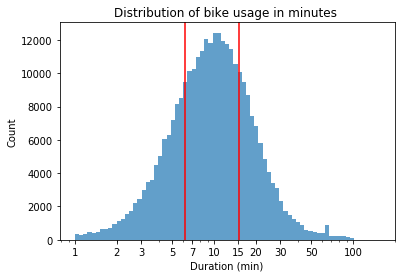

In [30]:
log_binsize = 10**np.arange(0,np.log10(tripdata_cleaned['duration_min']).max() +0.2,0.03)
plt.hist(data=tripdata_cleaned, x='duration_min',bins = log_binsize,alpha = 0.7)
plt.title('Distribution of bike usage in minutes ')
plt.xscale('log')
x_tick=[1,2,3,5,7,10,15,20,30,50,100]
plt.xticks(x_tick,x_tick)
plt.xlabel('Duration (min)')
plt.axvline(x=6.15, color='r') ## This line shows upperbond of data - 25% quartile
plt.axvline(x=15.2, color='r') ## This line shows upperbond of data - 75% quartile
plt.ylabel('Count')
plt.show()

### Split of Users (Subscribers vs Customers) 
There were more subscribers than customers, the splits were 58% and 42% respectively. 

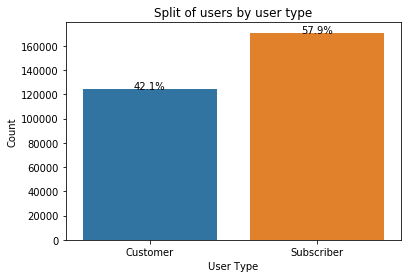

In [31]:
sb.countplot(data=tripdata_cleaned, x='user_type')
plt.title('Split of users by user type')
plt.xlabel('User Type')
plt.ylabel('Count')
# add annotations
n_points = tripdata_cleaned.shape[0]
utype_counts = tripdata_cleaned['user_type'].value_counts()
locs, labels = plt.xticks() # get the current tick locations and labels

# loop through each pair of locations and labels
for loc, label in zip(locs, labels):

    # get the text property for the label to get the correct count
    count = utype_counts[label.get_text()]
    pct_string = '{:0.1f}%'.format(100*count/n_points)

    # print the annotation just below the top of the bar
    plt.text(loc, count-8, pct_string, ha = 'center', color = 'black')

plt.show()

### Distribution of Start Time of Bike Rentals
The bar chart below shows bimodal distribution of data. The number of users started to climb up at 6 am until 8 am, then dropped to a steady level from 10am to 3pm, then it started to rise again with its highest number of users during the day at 5pm.

In [32]:
tripdata_cleaned['start_time'] = pd.to_datetime(tripdata_cleaned['start_time'])

In [33]:
#I am going to create an extra column to extract the hour of the start_time
tripdata_cleaned['start_hour'] = tripdata_cleaned.start_time.dt.hour

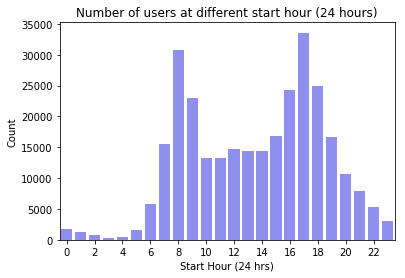

In [34]:
figsize=[6,8]
sb.countplot(data=tripdata_cleaned, x='start_hour',alpha=0.5,color = 'b')
xticks = [0,2,4,6,8,10,12,14,16,18,20,22]
plt.xticks(xticks,xticks)
plt.xlabel('Start Hour (24 hrs)')
plt.ylabel('Count')
plt.title('Number of users at different start hour (24 hours)')
plt.show()

### Split Between Return Locations
Most customers (98.8%) actually returned the bike at a different location.

In [35]:
tripdata_cleaned['start_combo'] = tripdata_cleaned[['start_station_latitude', 'start_station_longitude']].apply(lambda x: ','.join(x.astype(str)), axis=1)
tripdata_cleaned['end_combo'] = tripdata_cleaned[['end_station_latitude', 'end_station_longitude']].apply(lambda x: ','.join(x.astype(str)), axis=1)


In [36]:
tripdata_cleaned = tripdata_cleaned.assign(return_trip = tripdata_cleaned.start_combo == tripdata_cleaned.end_combo)

In [37]:
same_depot = round(tripdata_cleaned['return_trip'].mean()*100,2)
same_depot

1.16

In [38]:
diff_depot = round((1-tripdata_cleaned['return_trip'].mean())*100,2)
diff_depot

98.84

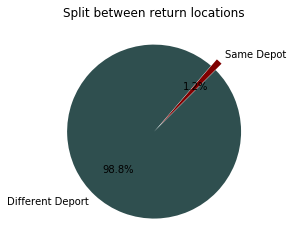

In [39]:
figsize = [6,8]
mean = [same_depot, diff_depot]
location = ['Same Depot', 'Different Deport']
explode = (0.1,0)
colors = ['maroon', 'darkslategray']
plt.pie(mean, labels=location, colors = colors,startangle=45, autopct='%.1f%%',explode=explode)
plt.title('Split between return locations')
plt.show()

### Distribution of Bike Rentals by Week Day
It is interesting to see that the number of bike rentals were not steady during weekdays, given that the data previously showed that most renters were taking bikes during office peak hours. Rentals on Sunday seemed also high, which contrasted to the number of rentals on Saturday.   

In [40]:
tripdata_cleaned['week_day'] = tripdata_cleaned.start_time.dt.dayofweek

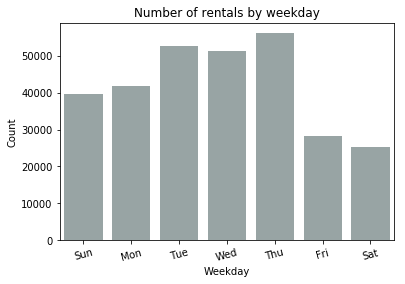

In [41]:
fig, ax = plt.subplots(1,1) 
x = np.arange(0,7,1)
sb.countplot(data =tripdata_cleaned, x='week_day',color='darkslategrey',alpha=0.5)
x_ticks_labels = ['Sun','Mon','Tue','Wed','Thu','Fri','Sat']

# Set number of ticks for x-axis
ax.set_xticks(x)
# Set ticks labels for x-axis
ax.set_xticklabels(x_ticks_labels, rotation=15, fontsize=10)
plt.title('Number of rentals by weekday')
plt.xlabel('Weekday')
plt.ylabel('Count')

plt.show()

### Duration (min) by User Type

The graphs below show the relationship between duration of rental and user type, i.e. casual customers and regular subscribers. Intereatingly, the lower and upper quartiles, and the median in these two segments of users are almost of the same. The boxplot does a slightly better job to show the differences of data distribution between these two segments, with subscribers' median, lower and upper quartiles being slightly lower than that of normal customers'. 

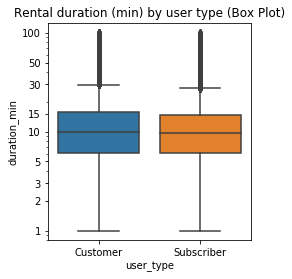

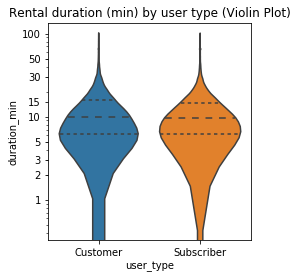

In [42]:
plt.figure(figsize = [8, 4])
plt.subplot(1,2,1)
log_binsize = 10**np.arange(0,np.log10(tripdata_cleaned['duration_min']).max() +0.2,0.03)
sb.boxplot(data = tripdata_cleaned, x = 'user_type', y = 'duration_min')
plt.title('Rental duration (min) by user type (Box Plot)')
plt.yscale('log')
y_tick=[1,2,3,5,10,15,30,50,100]
plt.yticks(y_tick,y_tick)
plt.show()

plt.figure(figsize = [8, 4])
plt.subplot(1,2,2)
log_binsize = 10**np.arange(0,np.log10(tripdata_cleaned['duration_min']).max() +0.2,0.03)
sb.violinplot(data = tripdata_cleaned, x = 'user_type', y = 'duration_min',inner = 'quartile')
plt.title('Rental duration (min) by user type (Violin Plot)')
plt.yscale('log')
y_tick=[1,2,3,5,10,15,30,50,100]
plt.yticks(y_tick,y_tick)
plt.show()

### Duration (min) by Start Hour 
There were usersrented bikes at different hour of the day for less than 20 minutes. Most of the longer rentals happened during the day, started at around 7am, at its highest at 1pm and started declining after 4pm. 

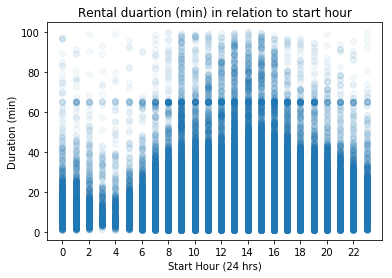

In [43]:
figsize=[12,8]
plt.scatter(data=tripdata_cleaned, x='start_hour',y='duration_min',alpha=0.05)
plt.xlabel('Start Hour (24 hrs)')
plt.ylabel('Duration (min)')
plt.title('Rental duartion (min) in relation to start hour')
x_ticks = [0,2,4,6,8,10,12,14,16,18,20,22]
plt.xticks(x_ticks,x_ticks)
plt.show()

### Number of Bike Rentals by Duration, Week Day and User Type

The differece between user types in relation to week days, and rental duration (min) is minimal. The distribution of the two groups (casual customers and subscribers) follow the same trajectory in terms of the number of rentals and duration of rentals on different days of the week. 

/Users/winnietong/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


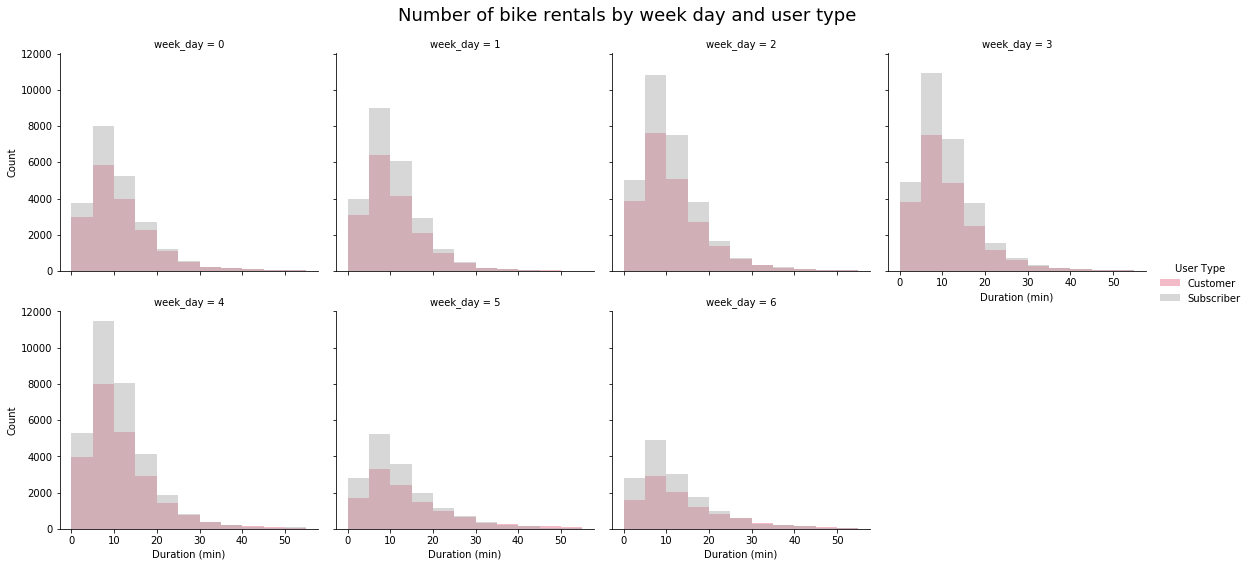

In [44]:

type_colour = {'Customer': '#e35675', 'Subscriber': '#9d9d9d'}
g = sb.FacetGrid(data = tripdata_cleaned, col = 'week_day',hue='user_type', col_wrap = 4, size = 4,palette= type_colour)
g.map(plt.hist, "duration_min",bins = np.arange(0,60, 5),alpha = 0.4 )
g.set_axis_labels(x_var="Duration (min)", y_var="Count").add_legend(title='User Type')
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Number of bike rentals by week day and user type', fontsize=18)
plt.show()


### Average Duration (min) by User Type and Week Day 

The point plot below shows, on average, from Sunday to Thursday, the average rental duration (min) between customers and subscribers are similar. However, on Friday and Saturday, the average duration of casual customers is at approx. 3 minutes longer than that of subscribers.  

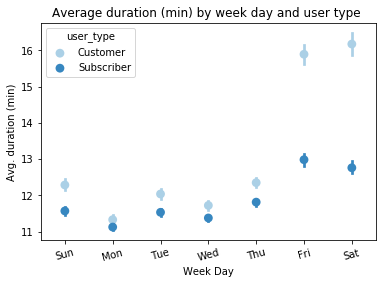

In [45]:
fig, ax = plt.subplots(1,1) 
sb.pointplot(data = tripdata_cleaned, x = 'week_day', y = 'duration_min',hue='user_type', linestyles = "",  palette = 'Blues')
plt.title('Average duration (min) by week day and user type ')
plt.xlabel('Week Day')
plt.ylabel('Avg. duration (min)') 
x = np.arange(0,7,1)
x_ticks_labels = ['Sun','Mon','Tue','Wed','Thu','Fri','Sat']

# Set number of ticks for x-axis
ax.set_xticks(x)
# Set ticks labels for x-axis
ax.set_xticklabels(x_ticks_labels, rotation=15, fontsize=10)
plt.show()

### Average Duration (min) by User Type and Return Location

The point plot below shows that users who returned the bike to the same location had a longer average duration (at least 17.5 minutes) on different week days, while users who returned the bike at a different location had a shorter average duraton of rental (less than 15 minutes) on different week days. The average duration was particularly high on Friday and Saturday for users who returned bikes at the same location.


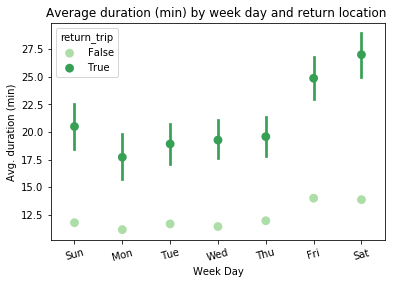

In [46]:
fig, ax = plt.subplots(1,1) 
sb.pointplot(data = tripdata_cleaned, x = 'week_day', y = 'duration_min',hue='return_trip', linestyles = "",  palette = 'Greens')
plt.title('Average duration (min) by week day and return location ')
plt.xlabel('Week Day')
plt.ylabel('Avg. duration (min)') 
x = np.arange(0,7,1)
x_ticks_labels = ['Sun','Mon','Tue','Wed','Thu','Fri','Sat']

# Set number of ticks for x-axis
ax.set_xticks(x)
# Set ticks labels for x-axis
ax.set_xticklabels(x_ticks_labels, rotation=15, fontsize=10)
plt.show()

In [47]:
!jupyter nbconvert slide_deck_template --to slides --post serve --template output_toggle

[NbConvertApp] Converting notebook slide_deck_template.ipynb to slides
[NbConvertApp] Writing 565967 bytes to slide_deck_template.slides.html
[NbConvertApp] Redirecting reveal.js requests to https://cdnjs.cloudflare.com/ajax/libs/reveal.js/3.5.0
Traceback (most recent call last):
  File "/Users/winnietong/anaconda3/bin/jupyter-nbconvert", line 11, in <module>
    sys.exit(main())
  File "/Users/winnietong/anaconda3/lib/python3.7/site-packages/jupyter_core/application.py", line 266, in launch_instance
    return super(JupyterApp, cls).launch_instance(argv=argv, **kwargs)
  File "/Users/winnietong/anaconda3/lib/python3.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Users/winnietong/anaconda3/lib/python3.7/site-packages/nbconvert/nbconvertapp.py", line 337, in start
    self.convert_notebooks()
  File "/Users/winnietong/anaconda3/lib/python3.7/site-packages/nbconvert/nbconvertapp.py", line 507, in convert_notebooks
    self.convert_